In [1]:
from __future__ import division, print_function
import numpy as np
%matplotlib inline

# Overview

- http://scikit-image.org/docs/stable/api/skimage.transform.html
- http://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.warp
- http://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.AffineTransform (and other similar classes)

# Image rotation from scratch

The following code shows how to rotate an image using the skimage (scikit-image) library.

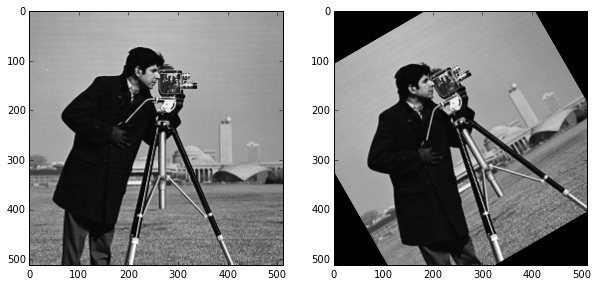

In [2]:
import matplotlib.pyplot as plt
from skimage import transform, data

camera = data.camera()
rotated = transform.rotate(camera, 30)

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
ax0.imshow(camera, cmap='gray')
ax1.imshow(rotated, cmap='gray');

<span style="font-size: 150%;">**Exercise:** Write an algorithm from scratch that will
do the same (i.e., take an input image as an ndarray, and rotate it).</span>

If you feel creative, you can also write code to magnify (zoom) the image.
<p></p>
You may need: http://en.wikipedia.org/wiki/Polar_coordinate_system
<p></p>
A (bad) solution is given below--but try it yourself before looking!

### A problematic approach

In [ ]:
from skimage import color

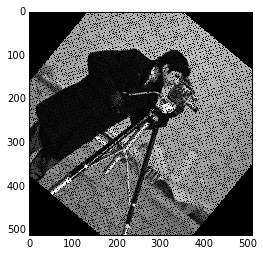

In [3]:
def rotate(image, theta):
    theta = np.deg2rad(theta)
    
    height, width = image.shape[:2]
    out = np.zeros_like(image)
    
    centre_x, centre_y = width / 2., height / 2.
    
    for x in range(width):
        for y in range(height):
            
            x_c = x - centre_x
            y_c = y - centre_y
            
            # Determine polar coordinate of pixel
            radius = np.sqrt(x_c**2 + y_c**2)
            angle = np.arctan2(y_c, x_c)
            
            new_angle = angle + theta
            
            new_x = radius * np.cos(new_angle)
            new_y = radius * np.sin(new_angle)
            
            new_x = new_x + centre_x
            new_y = new_y + centre_y
            
            if (new_x >= width) or (new_x < 0) or\
               (new_y >= height) or (new_y < 0):
                    continue
            else:
                out[int(new_y), int(new_x)] = image[y, x]
    
    return out

rotated = rotate(camera, 40)
    
plt.imshow(rotated, cmap='gray', interpolation='nearest');

## And while we can attempt to fix the problem...

...this is not an optimal approach

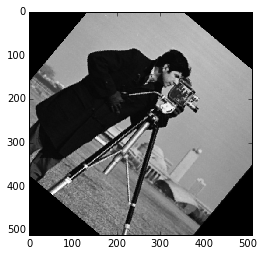

In [4]:
# Attempt at fixing the holes using a median filter
# -- it works, sort of, but it's not the best approach.

height, width = rotated.shape[:2]

out = rotated.copy()

for x in range(1, width - 1):
    for y in range(1, height - 1):
        if out[y, x] == 0:
            out[y, x] = np.median([out[y, x-1],
                                   out[y, x+1],
                                   out[y+1, x],
                                   out[y-1, x]])
            
plt.imshow(out, cmap='gray', interpolation='nearest');

In [ ]:
A = np.array([[4, 2], [1, 6]])
print(A)

In [ ]:
plt.imshow(A, cmap='gray', interpolation='nearest');

# For later discussion: interpolation

## Bi-linear interpolation

<img src="Bilinear_interpolation.png" style="float: left;"/>
<div style="clear: both;"/>

Also see [bilinear interpolation on Wikipedia](http://en.wikipedia.org/wiki/Bilinear_interpolation)

# Some warping experiments!

## Fish-eye

In [5]:
from skimage import transform, data, io
import numpy as np
import matplotlib.pyplot as plt

# Load face
face = io.imread('../images/stefan.jpg')

# Get the eye nicely in the middle
face = face[:185, 15:]

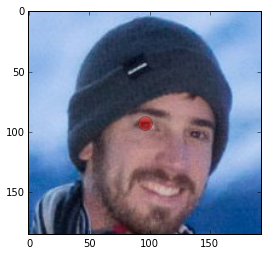

In [6]:
plt.imshow(face)
plt.plot([face.shape[1]/2.], [face.shape[0]/2.], 'or', markersize=14, alpha=0.4)
plt.axis('image');

In [7]:
# Define a transformation on the x-y coordinates

def fisheye(xy):
    center = np.mean(xy, axis=0)
    xc, yc = (xy - center).T

    # Polar coordinates
    r = np.sqrt(xc**2 + yc**2)
    theta = np.arctan2(yc, xc)

    r = 0.8 * np.exp(r**(1/2.1) / 1.8)

    return np.column_stack((r * np.cos(theta), r * np.sin(theta))) + center

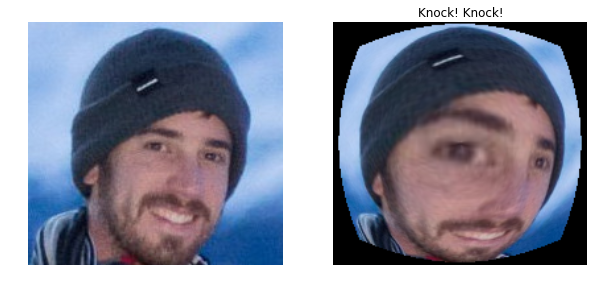

In [8]:
# Warp and display

out = transform.warp(face, fisheye)

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
ax0.imshow(face)
ax0.set_axis_off()

ax1.imshow(out)
ax1.set_axis_off()

plt.title('Knock! Knock!')
plt.show()

## Run the following scripts for fun:

(Open up the terminal in the "scripts" directory first)

- **deswirl.py** (run using: ``python deswirl.py``)

    In the UK, a criminal tried to hide his identity by posting
    swirled pictures of his face online.  Here, we use the
    Mona Lisa to illustrate what he did.  Can you restore
    her face back to normal? (Note that you can adjust the
    position of the red dot, as well as move the sliders.)
    
    
- **clock_deblur.py**

    I took a picture of a wall clock while moving the camera.  Or perhaps the clock moved.
    Either way, now I cannot read the time!  I've implemented a deblurring
    algorithm--can you adjust its parameters to help me pin-point
    the time?

# Here's code for a swirl transform:

In [9]:
from skimage import transform

def swirl(xy, center=[0, 0], strength=1, radius=100, rotation=0):
    """Compute the coordinate mapping for a swirl transformation.

    """
    x, y = xy.T
    x0, y0 = center
    rho = np.sqrt((x - x0)**2 + (y - y0)**2)

    # Ensure that the transformation decays to approximately 1/1000-th
    # within the specified radius.
    radius = radius / 5 * np.log(2)

    theta = rotation + strength * \
            np.exp(-rho / radius) + \
            np.arctan2(y - y0, x - x0)

    xy[..., 0] = x0 + rho * np.cos(theta)
    xy[..., 1] = y0 + rho * np.sin(theta)

    return xy


h, w = face.shape[:2]

parameters = {'center': [w/2., h/2.],
              'strength': 8,
              'radius': 90,
              'rotation':  0}

out = transform.warp(face, swirl, parameters)

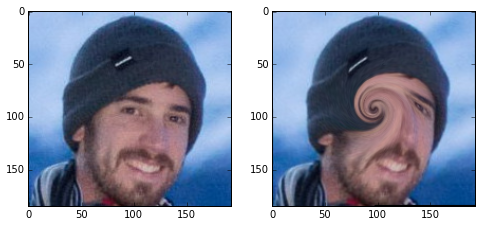

In [10]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))

ax0.imshow(face)
ax1.imshow(out);

# Can you come up with an even better distortion?

## Start with this template:

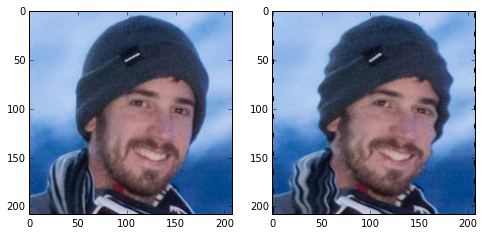

In [11]:
def my_warp(xy):
    x = xy[:, 0]
    y = xy[:, 1]
    
    x = x + 1.5 * np.sin(y / 3)
    
    return np.hstack((x, y))

image = plt.imread('../images/stefan.jpg')
out = transform.warp(image, my_warp)

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))
ax0.imshow(image)
ax1.imshow(out);

## Composing Transformations

scikit-image allows you to compose several transformations.  For example:

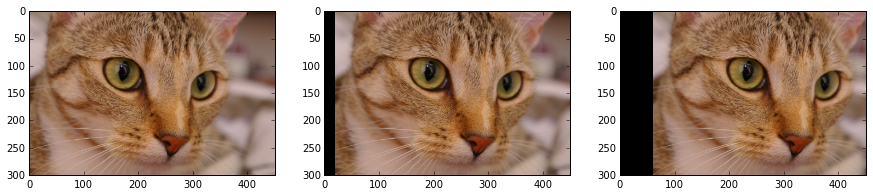

In [12]:
from skimage import data

cat = data.chelsea()
horizontal_shift = transform.SimilarityTransform(translation=[20, 0])

multiple_shifts = horizontal_shift + horizontal_shift + horizontal_shift

f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 5))
ax0.imshow(cat)
ax1.imshow(transform.warp(cat, horizontal_shift.inverse))    # Note the inverse!
ax2.imshow(transform.warp(cat, multiple_shifts.inverse));

The `transform` module allows us to rotate images.  The inner workings is something like this:

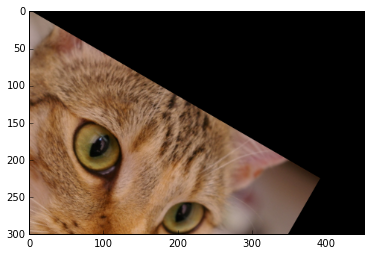

In [13]:
def my_rotate(image, angle):
    rotation_tf = transform.SimilarityTransform(rotation=np.deg2rad(angle))
    return transform.warp(image, rotation_tf.inverse)

plt.imshow(my_rotate(cat, 30))

Note that this rotates the cat around the origin (top-left).

**Can you modify `my_rotate` to rotate the image around the center?**

*Hint:*

1. Shift the image (see above) so that the center of the image lies at (0, 0)
2. Rotate the image
3. Shift the image back---the opposite of what you did in step 1

All of this can be achieved by composing transformations and calling `warp` once.

# Advanced challenge: rectifying an image

<img src="../images/chapel_floor.png" style="float: left;"/>

We know the above tiles are laid out in a square--can you transform
the image so that the tiles are displayed as if you were viewing them from above?

The centre-points of the corner circles are, given as (row, column) coordinates:

```
(72, 129) -- top left
(76, 302) -- top right
(185, 90) -- bottom left
(193, 326) -- bottom right
```

Hint: there is a linear transformation matrix, $H$, such that

$H \mathbf{x} = \mathbf{x}'$

where $\mathbf{x}$ is the *homogeneous* coordinate in the original image and
$\mathbf{x}'$ is the *homogeneous* coordinate in the rectified image (with *homogeneous*
we simply mean that we add an extra 1 at the end, e.g. (72, 129) becomes (72, 129, 1).
The values for $\mathbf{x}$ and their new values, $\mathbf{x}'$,
are therefore:

```
x = (72, 129, 1), x' = (0, 0, 1)
x = (76, 302, 1), x' = (0, 400, 1)
x = (185, 90, 1), x' = (400, 0, 1)
x = (193, 326, 1) x' = (400, 400, 1)
```

(You can choose any output size you like--I chose $400 \times 400$)

Why do we need homogeneous coordinates?  It allows us to have *translation* as part of H:

$
\left[\begin{array}{ccc}
H_{00} & H_{01} & H_{02}\\
H_{10} & H_{11} & H_{12}\\
H_{20} & H_{21} & 1
\end{array}\right]\left[\begin{array}{c}
x\\
y\\
1
\end{array}\right]=\left[\begin{array}{c}
H_{00}x+H_{01}y+H_{02}\\
H_{10}x+H_{11}y+H_{12}\\
H_{20}x+H_{21}y+H_{22}
\end{array}\right]
$

Note that each element of the output coordinate is of the form $ax + by + c$.  Without the 1 in the last position of the coordinate, there would have been no $+ c$ and therefore no translation!

The question on how to determine $H$ is left for another day.  If you are curious, 
the [answer can be found here](homography.pdf).

In the meantime, I provide some code to calculate $H$:

In [14]:
from skimage.transform import estimate_transform

source = np.array([(129, 72),
                   (302, 76),
                   (90, 185),
                   (326, 193)])

target = np.array([[0, 0],
                   [400, 0],
                   [0, 400],
                   [400, 400]])

tf = estimate_transform('projective', source, target)
H = tf.params
print(H)

[[  1.95534476e+00   6.74853501e-01  -3.00828926e+02]
 [ -9.26999636e-02   4.00927342e+00  -2.76709391e+02]
 [  1.69547283e-05   2.68639676e-03   6.43148662e-01]]


Using the code in the cell above, you can compute the target coordinate of any position in the original image.

In [15]:
# Verify that the top left corner maps to (0, 0)

x = np.array([[129, 72, 1]])

z = np.dot(H, x.T)
z /= z[2]

print(z)

[[ 0.]
 [ 0.]
 [ 1.]]


### Here's a template solution:

In [17]:
def rectify(xy):
    x = xy[:, 0]
    y = xy[:, 1]
    
    # We need to provide the backward mapping, from the target
    # image to the source image.
    HH = np.linalg.inv(H)
    
    # You must fill in your code here to take
    # the matrix HH (given above) and to transform
    # each coordinate to its new position.
    # 
    # Hint: handy functions are
    #
    # - np.dot (matrix multiplication)
    # - np.ones_like (make an array of ones the same shape as another array)
    # - np.column_stack
    # - A.T -- type .T after a matrix to transpose it
    # - x.reshape -- reshapes the array x
    
    # ... your code
    # ... your code
    # ... your code
    # ... your code
    
    return ...

    
image = plt.imread('../images/chapel_floor.png')
out = transform.warp(image, rectify, output_shape=(400, 400))

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))
ax0.imshow(image)
ax1.imshow(out)

AttributeError: 'ellipsis' object has no attribute 'T'

<div style="height: 100px;">&nbsp;</div>

<div>
The solution to the above problem is provided as [solutions/tile_rectify.py](solutions/tile_rectify.py).  Only look at it after you've attempted the problem yourself!
</div>

# For more fun examples see http://scikit-image.org/docs/dev/auto_examples